In [3]:
import numpy as np
from tensorflow import keras
from tools import signature as sig
from sklearn.preprocessing import StandardScaler

from ipywidgets import interact, fixed
import ipywidgets as widgets
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from ipywidgets import Image, Layout
import PIL.Image
import io

In [4]:
# Téléchargement des données
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin)= \
        keras.datasets.mnist.load_data(path='all_mnist.npz')

In [7]:
keep = [1, 7]
keep.sort()
n = 100

keep.sort()
(x, y), (x_test, y_test) = sig.pretraitement(x_train_origin, y_train_origin, 
                                                 x_test_origin, y_test_origin, 
                                                 keep=keep, n=n, verbose=False)

copy = x

In [56]:
anomalie = 1

(x_anomalies, y_anomalies), (x_test_a, y_test_a) = sig.pretraitement(x_train_origin, y_train_origin, 
                                                 x_test_origin, y_test_origin, 
                                                 keep=[anomalie], n=n, verbose=False)

copy = x.copy()
copy = np.append(copy,x_anomalies,axis=0)

copy.shape



(300, 784)

INFO:tensorflow:Assets written to: ./models/signature_all_100/assets
Best K values:  [2, 2]


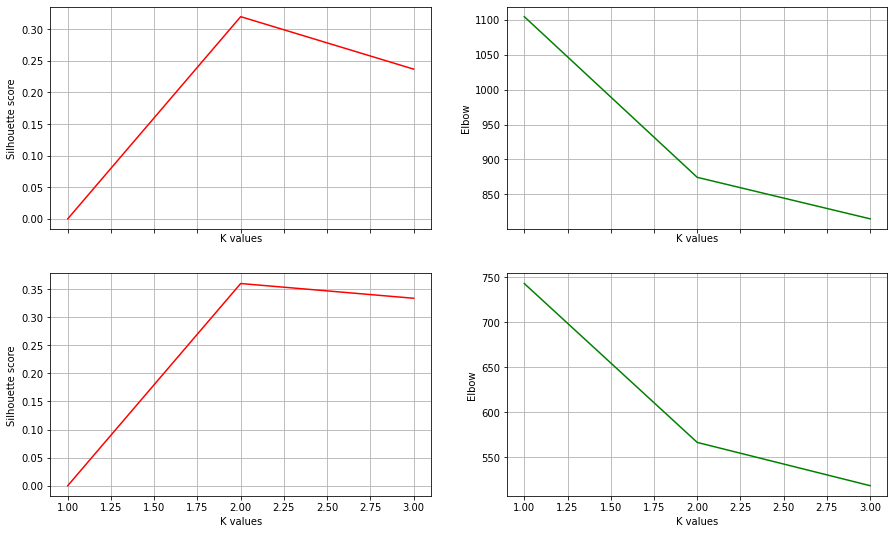

In [13]:
#jsonfilename = "./json/signature_all_100.json"
model_name="./models/signature_all_100"
model = sig.trained_model(x, y, hidden_layers=[32, 16],
                          model_name=model_name, verbose=False,load=False)

predictions = sig.get_preditions(model, copy, keep, verbose=False)

labels = [keep[np.argmax(l)] for l in y]
#labels += [anomalie for l in y_anomalies]


hidden_layers = model.get_hidden_layers_outputs(copy)

for i in range(len(hidden_layers)):
    hidden_layers[i] = StandardScaler().fit_transform(hidden_layers[i])

best_k = sig.get_best_k(hidden_layers, kmax = len(keep)+1,verbose=True)
clusters = sig.clustering(hidden_layers, best_k)



In [9]:
dictionary_data = dict()

dictionary_data['x'] = x.tolist()
dictionary_data['predictions'] = predictions.tolist()
dictionary_data['hidden_layers'] = [e.tolist() for e in hidden_layers]
dictionary_data['clusters'] = [e.tolist() for e in clusters]
dictionary_data['labels'] = [int(e) for e in labels]
dictionary_data['keep'] = keep
dictionary_data['best_k'] = [int(e) for e in best_k]

#sig.saveJson(jsonfilename, dictionary_data)

In [10]:
# Build colorscale
colorscale = {
    'color': np.zeros(len(copy), dtype='uint8'),
    'colorscale': ['grey', '#ee1717', '#7201a8', '#17a60d', '#291ae0', '#f418ff', '#e3ae04', 
                    '#fb5e09', 'black', '#0ed6e1', '#d35400'],
    'cmin': 0,
    'cmax': 10
}

#dict_data = sig.loadJson(jsonfilename)
#dict_data['hidden_layers'] = [np.array(e) for e in dict_data['hidden_layers']]

traces = sig.umap_plot(copy, labels, predictions, hidden_layers, clusters, colorscale)

parcats = sig.parcats(labels,keep, best_k, clusters, predictions, colorscale)

traces.append(parcats)

In [11]:
def image_to_byte_array(image):
    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format='png')
    imgByteArr = imgByteArr.getvalue()
    return imgByteArr

def to_image(x):
    return  image_to_byte_array(
                PIL.Image.fromarray(
                    (x.reshape(28 , 28) * 255).astype(np.uint8)
                ))

# Update color callback
def update_color(trace, points, state):
    # Compute new color array
    new_color = np.array(trace.marker.color)
    new_color[points.point_inds] = color_toggle.index
    with fig.batch_update():
        # Update scatter color
        for i in range(len(fig.data)-1):
            fig.data[i].marker.color = new_color

        # Update parcats colors
        fig.data[len(fig.data)-1].line.color = new_color
        
# Update color callback
def update_parcats_color(trace, points, state):
    # Compute new color array
    new_color = np.array(trace.line.color)
    new_color[points.point_inds] = color_toggle.index
    with fig.batch_update():
        # Update scatter color
        for i in range(len(fig.data)-1):
            fig.data[i].marker.color = new_color

        # Update parcats colors
        fig.data[len(fig.data)-1].line.color = new_color
        
def print_image(trace, points, state):     
    # Image update
    if (points.point_inds != []):
        image_widget.value = to_image(copy[points.point_inds[0]])

In [12]:
fig = make_subplots(rows=3, figure=go.FigureWidget(), specs=[[{'type': 'xy'}],
                                                             [{'type': 'xy'}],
                                                            [{'type': 'parcats'}]])

fig.add_traces(traces, rows=[1, 2, 3], cols=[1, 1, 1])

fig.update_layout(height=800,
                    dragmode='lasso', hovermode='closest')

# Build color selection widget
color_toggle = widgets.ToggleButtons(
    options=['None', 'Red', 'Purple', 'Green', 'Blue', 'Pink', 
                 'Yellow', 'Orange','Black' ,'Aqua', 'Brown'],
    index=1, description='Color:', disabled=False)
    
image_widget = Image(
    value=to_image(x[0]),
    layout=Layout(height='100px', width='100px')
)

# Register callback on scatter selection...
fig.data[0].on_selection(update_color)
fig.data[1].on_selection(update_color)

fig.data[0].on_hover(print_image)
fig.data[1].on_hover(print_image)

# and parcats click
fig.data[2].on_click(update_parcats_color)

# Display figure
widgets.VBox([color_toggle, image_widget, fig])